# Idea general (qué estás implementando)

Vamos a implementar la estructura clásica de una GAN:

- Generador 𝐺(z)
	- Entrada: vector de ruido z ∈ R^100 (distribución normal o uniforme).
	- Salida: imagen 1×28×28 que “parece” MNIST.
	- Arquitectura: Linear → reshape → ConvTranspose2d → ConvTranspose2d → Tanh.

- Discriminador 𝐷(x)
	- Entrada: imagen real o generada x ∈ R^{1×28×28}.
	- Salida: probabilidad D(x) ∈ (0,1) de que la imagen sea real.
	- Arquitectura: Conv2d → Conv2d → Linear → Sigmoid.

Función de pérdida:

Discriminador:

$$𝐿_{𝐷} = −𝐸_{𝑥∼𝑝_{data}}[log𝐷(𝑥)] − 𝐸_{𝑧∼𝑝_{𝑧}}[log(1−𝐷(𝐺(𝑧)))]$$
	​



Generador:

$$𝐿_{G} = −𝐸_{z~p_{z}}[logD(G(z))]$$


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import os

In [2]:
# ===========================
# 1. Hyperparámetros
# ===========================
latent_dim = 100       # dimensión del vector de ruido z
batch_size = 128
num_epochs = 20
lr = 2e-4
beta1 = 0.5            # para Adam, típico en DCGAN

image_size = 28
image_channels = 1     # MNIST es en escala de grises

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
# Carpeta para guardar resultados
os.makedirs("samples", exist_ok=True)
# ===========================

In [4]:
# ===========================
# 2. Dataset y DataLoader
# ===========================
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalizamos a media 0 y varianza 1 en [-1, 1] (para Tanh en la salida del generador)
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 289kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 27.7MB/s]


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Shape of image tensor: torch.Size([1, 28, 28]), Label: 5


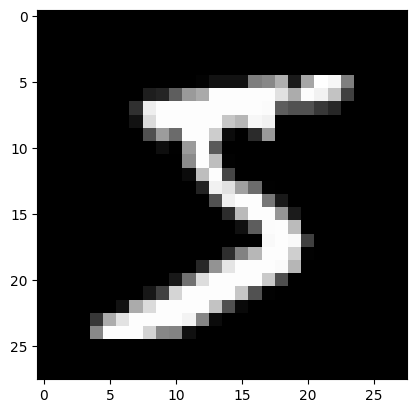

In [18]:
aux1 = train_loader.dataset.__getitem__(0)  # Verificar que el dataset carga correctamente
print(f"Shape of image tensor: {aux1[0].shape}, Label: {aux1[1]}")
plt.imshow(aux1[0].squeeze_(0), cmap="gray")

In [19]:
# ===========================
# 3. Definición del Generador
# ===========================
class Generator(nn.Module):
    """
    Generador G: mapea un vector de ruido z (latent_dim) a una imagen 1x28x28.
    Usamos una combinación de capas lineales y convoluciones transpuestas.
    """
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            # Entrada: (256, 7, 7)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, image_channels, kernel_size=4, stride=2, padding=1),  # -> (1, 28, 28)
            nn.Tanh()  # salida en [-1, 1]
        )

    def forward(self, z):
        # z: (batch_size, latent_dim)
        x = self.fc(z)  # (batch_size, 256*7*7)
        x = x.view(-1, 256, 7, 7)  # reshape a (batch_size, 256, 7, 7)
        img = self.conv_blocks(x)  # (batch_size, 1, 28, 28)
        return img

In [20]:

# ===========================
# 4. Definición del Discriminador
# ===========================
class Discriminator(nn.Module):
    """
    Discriminador D: recibe una imagen 1x28x28 y devuelve probabilidad de ser real.
    """
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_blocks = nn.Sequential(
            # Entrada: (1, 28, 28)
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()  # probabilidad de "real"
        )

    def forward(self, img):
        x = self.conv_blocks(img)
        out = self.fc(x)
        return out

In [21]:
# ===========================
# 5. Inicialización de modelos, pérdidas y optimizadores
# ===========================
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


# Función para inicializar pesos como recomienda DCGAN
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 or classname.find("Linear") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


G.apply(weights_init_normal)
D.apply(weights_init_normal)


# ===========================
# 6. Bucle de entrenamiento
# ===========================
fixed_noise = torch.randn(64, latent_dim, device=device)  # para monitorear generación a lo largo de los epochs

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size_cur = real_imgs.size(0)

        # -----------------------------
        # a) Entrenamiento del Discriminador
        # -----------------------------
        D.zero_grad()

        # Etiquetas para real y fake
        real_labels = torch.ones(batch_size_cur, 1, device=device)
        fake_labels = torch.zeros(batch_size_cur, 1, device=device)

        # 1) Pérdida con imágenes reales
        outputs_real = D(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        # 2) Pérdida con imágenes falsas (generadas)
        z = torch.randn(batch_size_cur, latent_dim, device=device)
        fake_imgs = G(z)

        outputs_fake = D(fake_imgs.detach())  # detach para no propagar gradiente a G
        loss_fake = criterion(outputs_fake, fake_labels)

        # Pérdida total del discriminador
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # -----------------------------
        # b) Entrenamiento del Generador
        # -----------------------------
        G.zero_grad()

        # Queremos que D(G(z)) ≈ 1 (es decir, engañar al discriminador)
        outputs_fake_for_G = D(fake_imgs)
        # NOTA: aquí usamos real_labels porque el generador quiere que sus imágenes sean clasificadas como "reales"
        loss_G = criterion(outputs_fake_for_G, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # -----------------------------
        # Logging básico
        # -----------------------------
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Lote [{batch_idx}/{len(train_loader)}] "
                  f"Loss D: {loss_D.item():.4f} "
                  f"Loss G: {loss_G.item():.4f}")

    # ===========================
    # 7. Guardar muestras por epoch
    # ===========================
    with torch.no_grad():
        fake_samples = G(fixed_noise).detach().cpu()
        # Des-normalizar de [-1,1] a [0,1] para guardar
        fake_samples = (fake_samples + 1) / 2.0
        utils.save_image(
            fake_samples,
            f"samples/fake_epoch_{epoch+1:03d}.png",
            nrow=8
        )

    # Opcional: guardar pesos
    torch.save(G.state_dict(), "G_mnist.pth")
    torch.save(D.state_dict(), "D_mnist.pth")

print("Entrenamiento finalizado.")

Epoch [1/20] Lote [0/469] Loss D: 2.2394 Loss G: 1.4114
Epoch [1/20] Lote [200/469] Loss D: 0.6591 Loss G: 1.1874
Epoch [1/20] Lote [400/469] Loss D: 0.6742 Loss G: 0.8961
Epoch [2/20] Lote [0/469] Loss D: 0.5210 Loss G: 1.1476
Epoch [2/20] Lote [200/469] Loss D: 0.4469 Loss G: 1.4531
Epoch [2/20] Lote [400/469] Loss D: 0.4902 Loss G: 2.1091
Epoch [3/20] Lote [0/469] Loss D: 0.5708 Loss G: 1.3695
Epoch [3/20] Lote [200/469] Loss D: 0.5920 Loss G: 2.6707
Epoch [3/20] Lote [400/469] Loss D: 0.6365 Loss G: 1.7608
Epoch [4/20] Lote [0/469] Loss D: 0.6961 Loss G: 1.9670
Epoch [4/20] Lote [200/469] Loss D: 0.6065 Loss G: 1.6875
Epoch [4/20] Lote [400/469] Loss D: 0.7979 Loss G: 0.8164
Epoch [5/20] Lote [0/469] Loss D: 0.6678 Loss G: 1.6995
Epoch [5/20] Lote [200/469] Loss D: 0.6442 Loss G: 1.1861
Epoch [5/20] Lote [400/469] Loss D: 0.5869 Loss G: 1.3354
Epoch [6/20] Lote [0/469] Loss D: 0.7621 Loss G: 1.3657
Epoch [6/20] Lote [200/469] Loss D: 0.6089 Loss G: 1.7130
Epoch [6/20] Lote [400/469

In [ ]:
# torch.save(G.state_dict(), "G_mnist.pth")
# latent_dim = 100
# G = Generator(latent_dim).to(device)
# G.load_state_dict(torch.load("G_mnist.pth", map_location=device))
# G.eval()   # modo inferencia

In [22]:
# Cantidad de imágenes a generar
n_samples = 64

# Vector de ruido aleatorio
z = torch.randn(n_samples, latent_dim).to(device)

# Generación
with torch.no_grad():
    fake_images = G(z)

# Las imágenes están en [-1, 1] por el Tanh → las llevamos a [0,1]
fake_images = (fake_images + 1) / 2

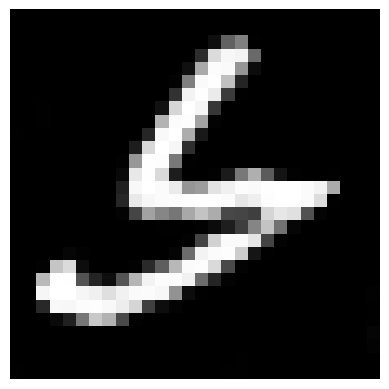

In [26]:
img = fake_images[9].cpu().squeeze()   # quitar dimensiones extra
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()